# Create and run Earthquake Estimator

In [1]:
!nvidia-smi

Mon Jan 21 21:17:27 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:81:00.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import tensorflow as tf
import lstm_estimator
import earthquake_input_fn
from importlib import reload
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [3]:
EARTHQUAKE_DATA_DIR = '/workspace/persistent-data/earthquake/tfrecords2'

In [4]:
def reload_tf():
    global lstm_estimator
    global earthquake_input_fn
    for i in range(2):
        import lstm_estimator
        import earthquake_input_fn
        reload(lstm_estimator)
        reload(earthquake_input_fn)
        del lstm_estimator
        del earthquake_input_fn
    import lstm_estimator
    import earthquake_input_fn

In [5]:
reload_tf()

In [6]:
def create_estimator_from_params(batch_size, timesteps, n_feats, feature_columns,
                                 lstm_cell_size, learning_rate, dropout_rate=0.5, label_input_column=None, model_dir=None):
    
    params = {
        'batch_size': batch_size,
        'timesteps': timesteps,
        'n_feats': n_feats,
        'feature_columns': feature_columns,
        'lstm_cell_size': lstm_cell_size,
        'learning_rate': learning_rate,
        'dropout_rate': dropout_rate,
        'label_input_column': label_input_column
    }
    if model_dir is None:
        model_dir = '/workspace/persistent-data/models/%s' % (time.strftime('%Y-%m-%d-%H-%M-%S'))
    estim = tf.estimator.Estimator(model_fn=lstm_estimator.lstm_model_fn,
                                   params=params,
                                   model_dir=model_dir)
    return estim

In [9]:
BATCH_SIZE=64
TIMESTEPS=32
LSTM_CELL_SIZE=[128, 64]
LEARNING_RATE=0.000075

In [10]:
estimator = create_estimator_from_params(batch_size=BATCH_SIZE,
                                         timesteps=TIMESTEPS,
                                         n_feats=1,
                                         feature_columns=[tf.feature_column.numeric_column(key='acousticdata',
                                                                                           dtype=tf.int64,
                                                                                           shape=(BATCH_SIZE, TIMESTEPS))],
                                         lstm_cell_size=LSTM_CELL_SIZE,
                                         learning_rate=LEARNING_RATE)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2e63782ba8>, '_tf_random_seed': None, '_is_chief': True, '_model_dir': '/workspace/persistent-data/models/2019-01-21-21-18-12', '_protocol': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_log_step_count_steps': 100, '_num_ps_replicas': 0, '_task_id': 0, '_master': '', '_train_distribute': None, '_task_type': 'worker', '_save_checkpoints_steps': None, '_global_id_in_cluster': 0, '_keep_checkpoint_every_n_hours': 10000, '_eval_distribute': None, '_device_fn': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_experimental_distribute': None, '_num_worker_replicas': 1, '_keep_checkpoint_max': 5, '_service': None, '_evaluation_master': ''}


In [ ]:
DISTINCT_BATCHES = 1323
STEPS_PER_BATCH = int(4096/TIMESTEPS)
TOTAL_STEPS = DISTINCT_BATCHES * STEPS_PER_BATCH
print('running estimator for %d steps' % TOTAL_STEPS)
estimator.train(input_fn=lambda: earthquake_input_fn.earthquake_input_fn2(EARTHQUAKE_DATA_DIR,
                                                                          BATCH_SIZE,
                                                                          TIMESTEPS,
                                                                          scales=['1e1', '1e0'],
                                                                          traintest='train'),
                steps=TOTAL_STEPS)

running estimator for 169344 steps
INFO:tensorflow:Calling model_fn.
FEATURES
{'acousticdata': <tf.Tensor 'IteratorGetNext:0' shape=(?, ?) dtype=int64>}
LABELS
Tensor("IteratorGetNext:1", shape=(?, ?), dtype=float64, device=/device:CPU:0)
MODE
train
PARAMS
{'batch_size': 64, 'learning_rate': 7.5e-05, 'timesteps': 32, 'n_feats': 1, 'feature_columns': [_NumericColumn(key='acousticdata', shape=(64, 32), default_value=None, dtype=tf.int64, normalizer_fn=None)], 'dropout_rate': 0.5, 'label_input_column': None, 'lstm_cell_size': [128, 64]}
[<tf.Tensor 'Assign:0' shape=(64, 128) dtype=float64_ref>, <tf.Tensor 'Assign_1:0' shape=(64, 128) dtype=float64_ref>, <tf.Tensor 'Assign_2:0' shape=(64, 128) dtype=float64_ref>, <tf.Tensor 'Assign_3:0' shape=(64, 128) dtype=float64_ref>, <tf.Tensor 'Assign_4:0' shape=(64, 64) dtype=float64_ref>, <tf.Tensor 'Assign_5:0' shape=(64, 64) dtype=float64_ref>, <tf.Tensor 'Assign_6:0' shape=(64, 64) dtype=float64_ref>, <tf.Tensor 'Assign_7:0' shape=(64, 64) dtype

In [13]:
PRED_BATCHES = 1
TOTAL_PRED_FILES = PRED_BATCHES * BATCH_SIZE
estimator = create_estimator_from_params(BATCH_SIZE,
                                         TIMESTEPS,
                                         1,
                                         feature_columns=[tf.feature_column.numeric_column(key='acousticdata',
                                                                                           dtype=tf.int64,
                                                                                           shape=(BATCH_SIZE, TIMESTEPS))],
                                         lstm_cell_size=LSTM_CELL_SIZE,
                                         learning_rate=LEARNING_RATE,
                                         label_input_column=[tf.feature_column.numeric_column(key='tminus',
                                                                                              dtype=tf.float64,
                                                                                              shape=(BATCH_SIZE, TIMESTEPS))],
                                         model_dir='/workspace/persistent-data/models/2019-01-21-18-51-50')
predictions = estimator.predict(lambda: earthquake_input_fn.earthquake_input_fn2_prediction(EARTHQUAKE_DATA_DIR,
                                                                                            BATCH_SIZE,
                                                                                            TIMESTEPS,
                                                                                            num_files=TOTAL_PRED_FILES,
                                                                                            scales=['1e0', '1e1'],
                                                                                            traintest='test'),
                                yield_single_examples=False)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_worker_replicas': 1, '_experimental_distribute': None, '_protocol': None, '_master': '', '_keep_checkpoint_every_n_hours': 10000, '_device_fn': None, '_global_id_in_cluster': 0, '_save_summary_steps': 100, '_eval_distribute': None, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_log_step_count_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7faada0a1d30>, '_train_distribute': None, '_model_dir': '/workspace/persistent-data/models/2019-01-21-18-51-50', '_task_type': 'worker', '_tf_random_seed': None, '_save_checkpoints_steps': None, '_is_chief': True, '_task_id': 0, '_save_checkpoints_secs': 600, '_evaluation_master': ''}


In [14]:
mae = 0.0
N_sub_batches = 4096 / TIMESTEPS
last_batch_idx = N_sub_batches - 1

for i, p in enumerate(predictions):
    
    labels = p['labels']
    preds = p['pred']
    
    # Only care about errors on the last timestep of the last batch
    
    if i == last_batch_idx:
        mae = np.abs(labels[:,-1] - preds[:,-1]).sum() / BATCH_SIZE
        mse = ((labels[:,-1] - preds[:,-1])**2).sum() / BATCH_SIZE
        
        mae_batch = np.abs(labels - preds).sum() / BATCH_SIZE
        mse_batch = ((labels - preds)**2).sum() / BATCH_SIZE
    
print('mae: %.5f' % mae)
print('mse: %.5f' % mse)
print('mae batch: %.5f' % mae_batch)
print('mse batch: %.5f' % mse_batch)

INFO:tensorflow:Calling model_fn.
{'tminus': <tf.Tensor 'IteratorGetNext:1' shape=(?, ?) dtype=float64>, 'acousticdata': <tf.Tensor 'IteratorGetNext:0' shape=(?, ?) dtype=int64>}
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /workspace/persistent-data/models/2019-01-21-18-51-50/model.ckpt-256
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
mae: 2.58151
mse: 10.59861
mae batch: 41.03840
mse batch: 169.18947


In [15]:
i

255

In [16]:
labels.dtype

dtype('float32')

In [17]:
preds.dtype

dtype('float64')

In [18]:
labels

array([[-5.2259955, -5.2259955, -5.2259955, ..., -5.2259955, -5.2259955,
        -5.2259955],
       [-1.7056955, -1.7056955, -1.7056955, ..., -1.7056955, -1.7056955,
        -1.7056955],
       [-1.6991955, -1.6991955, -1.6991955, ..., -1.6991955, -1.6991955,
        -1.6991955],
       ...,
       [-2.5403955, -2.5403955, -2.5403955, ..., -2.5403955, -2.5403955,
        -2.5403955],
       [-1.1667955, -1.1667955, -1.1667955, ..., -1.1667955, -1.1667955,
        -1.1667955],
       [-4.2195954, -4.2195954, -4.2195954, ..., -4.2195954, -4.2195954,
        -4.2195954]], dtype=float32)

In [19]:
preds

array([[-6.39381525, -6.34407812, -6.07519493, ..., -6.40602068,
        -5.95761456, -6.3772099 ],
       [-4.60742331, -4.75285129, -4.52816296, ..., -4.6032322 ,
        -4.28710789, -4.65687966],
       [-5.44281503, -5.23884379, -5.13997829, ..., -5.47228008,
        -5.17700616, -5.36347641],
       ...,
       [-6.24999416, -6.21505803, -6.46709088, ..., -6.1611161 ,
        -6.37439961, -6.14457805],
       [-6.7952206 , -6.63778415, -6.71463676, ..., -6.44360682,
        -6.71519196, -6.63341746],
       [-6.04155592, -6.0581712 , -6.14465133, ..., -5.97205959,
        -6.08115307, -5.82669688]])

In [20]:
pd.Series(labels[1]).diff().abs().sum()

0.0

In [21]:
s = 0.0
for i in range(64):
    if pd.Series(labels[i]).diff().abs().sum() > 0.0:
        print(i)
        print(labels[i])
        print('----------------')
s

6
[-0.48219553 -0.48219553 -0.48219553 -0.48219553 -0.48219553 -0.48219553
 -0.48219553 -0.4821955  -0.4821955  -0.4821955  -0.4821955  -0.4821955
 -0.4821955  -0.4821955  -0.4821955  -0.4821955 ]
----------------
8
[-0.39669552 -0.39669552 -0.39669552 -0.39669552 -0.39669552 -0.39669552
 -0.39669552 -0.39669552 -0.39669552 -0.39669552 -0.39669552 -0.39669552
 -0.39669552 -0.39669552 -0.3966955  -0.3966955 ]
----------------
13
[-0.65269554 -0.65269554 -0.65269554 -0.6526955  -0.6526955  -0.6526955
 -0.6526955  -0.6526955  -0.6526955  -0.6526955  -0.6526955  -0.6526955
 -0.6526955  -0.6526955  -0.6526955  -0.6526955 ]
----------------
32
[-6.7773957 -6.7773957 -6.7773957 -6.7773957 -6.7773957 -6.7773957
 -6.7773957 -6.7773957 -6.7773957 -6.7773957 -6.7773957 -6.7773957
 -6.7773957 -6.7773957 -6.7773952 -6.7773952]
----------------
41
[-0.40069553 -0.40069553 -0.40069553 -0.40069553 -0.40069553 -0.40069553
 -0.40069553 -0.40069553 -0.40069553 -0.4006955  -0.4006955  -0.4006955
 -0.40069

0.0

In [21]:
pd.Series(labels[0]).diff().sum()

0.0

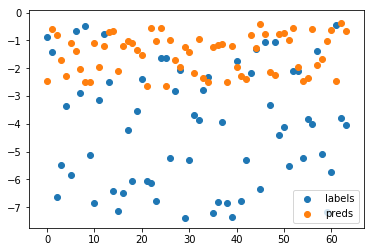

In [99]:
plt.scatter(range(64), labels[:,-1], label='labels')
plt.scatter(range(64), preds[:,-1], label='preds')
plt.legend()
plt.show()